# Airbnb New Users Bookings

## Project Overview
New users on Airbnb can book a place to stay in 34,000+ cities across 190+ countries. By accurately predicting where a new user will book their first travel experience, Airbnb can share more personalized content with their community, decrease the average time to first booking, and better forecast demand.

In this competition, the challenge is to predict in which country a new user will make his or her first booking. The data is composed of a list of users along with their demographics, web session records, and some summary statistics. All the users in this dataset are from the USA.

For each new user, a maximum of 5 predictions on the country of the first booking will be accepted. There are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other' (there was a booking, but is to a country not included in the list). The destination country predictions must be ordered such that the most probable destination country goes first.

## Data Import and Exploration

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

# SK-learn libraries for data processing.
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

# SK-learn libraries for learning.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier    
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation.
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data using pandas.
train_data = pd.read_csv('data/train_users_2.csv')
test_data = pd.read_csv('data/test_users.csv')
print "Train data shape: {0}".format(train_data.shape)
print "--------------Train Data----------------------"
print train_data.info()
print "----------------------------------------------"

print "\n"
print "Test data shape: {0}".format(test_data.shape)
print "---------------Test Data----------------------"
print test_data.info()
print "----------------------------------------------"

Train data shape: (213451, 16)
--------------Train Data----------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float

### Analysis of Class Distribution

Check training data to see how classes are distributed. It is obvious the training data is heavily imbalanced. This presented challenges for our models when identifying and predicting the minority classes.

NDF      0.583473
US       0.292226
other    0.047290
FR       0.023532
IT       0.013282
GB       0.010888
ES       0.010536
CA       0.006690
DE       0.004971
NL       0.003570
AU       0.002525
PT       0.001017
Name: country_destination, dtype: float64


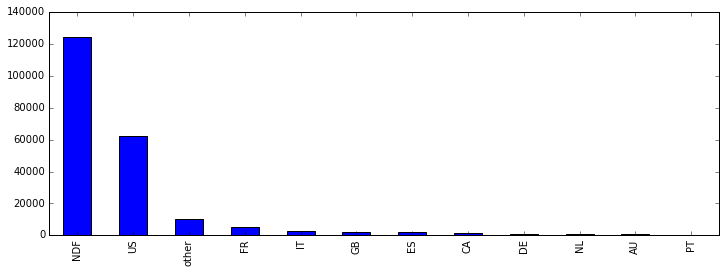

In [3]:
plt.figure(figsize=(12,4))
country_dist = train_data["country_destination"].value_counts()
plt.subplot(1,1,1)
country_dist.plot.bar()

print country_dist*1.0 / sum(country_dist)

### Analysis of age data
We'll start with the assumption that valid age ranges should be between 18-100 since the minimum age according to the Terms of Service is 18. Any values outside of this range should be cleaned into valid values or set to 0 as invalid.

The chart below shows a histogram of all age data.

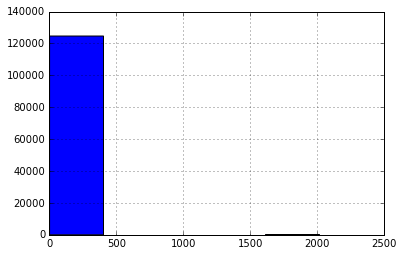

In [4]:
# Get all age values that are greater than zero.
GTE_zero_age = train_data[train_data.age >= 0].age
# Plot a histogram of these values.
GTE_zero_age.hist(bins=5)

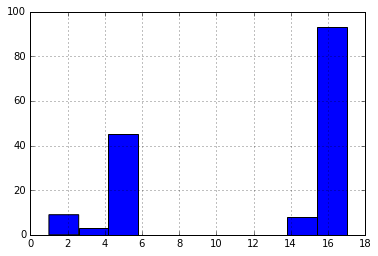

In [5]:
# Get all age values that are between 0 and 18.
under_18 = GTE_zero_age[GTE_zero_age < 18]
under_18.hist()

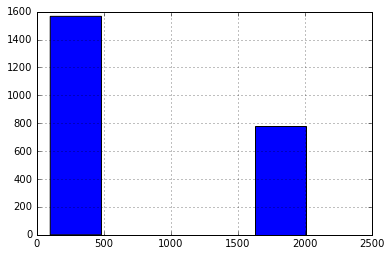

In [6]:
# From this, we can see that there are many large values.
# Assuming anything above 100 is not a valid, let's plot the histogram of those values.
GT_150 = train_data[train_data.age > 100].age
GT_150.hist(bins=5)
# We can't make much sense out of values between 100-1915 so
# those should be treated as invalid values as well.

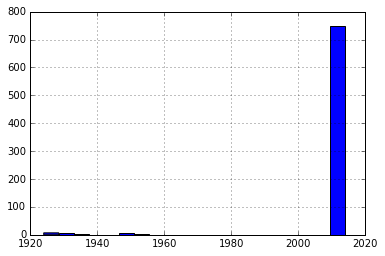

In [7]:
# Let's look more closely at those values greater than 1915.
GT_1915 = train_data[train_data.age > 1915].age
GT_1915.hist(bins=20)
# We have some values between 1915 and 1997 which we can
# assume could be birth years.
# The large number of values > 1997 are likely the current
# year the user registered.

#### Cleaning Age Data
Based on our analysis, we wrote a function to re-code invalid age data as appropriate. This function is applied to both the training and test datasets.

In [41]:
# Helper function to clean up the age data
def CleanAgeData(df):
    age_data = df.age
    # Set missing values to -1.
    age_data = age_data.fillna(0)
    # Set invalid values to 0.
    # Values between 0-18 are considered invalid.
    age_data[age_data.isin(range(0,18))] = 0
    # Values between 100-1915 are considered invalid.
    age_data[age_data.isin(range(101,1915))] = 0
    # Values >2010 are considered invalid.
    age_data[age_data > 1997] = 0
    # Compute age for values between 1915-1997.
    age_data[age_data.isin(range(1915,1998))] = 2015 - age_data[age_data.isin(range(1915,1998))]
    return age_data

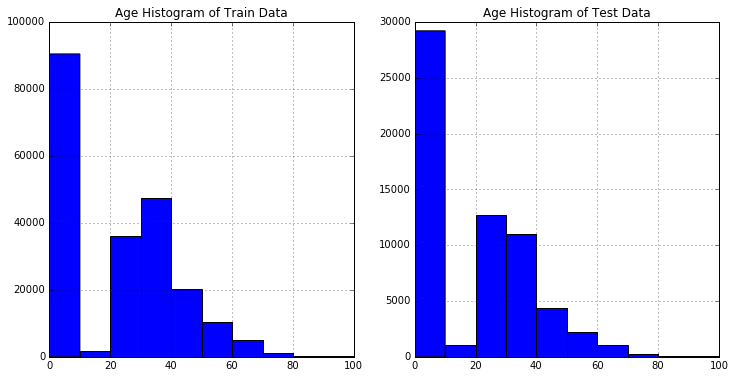

In [42]:
# Clean up training and test age data and plot cleaned data.
plt.figure(figsize=(12, 6))
train_age_data = CleanAgeData(train_data)
plt.subplot(1, 2, 1)
train_age_data.hist(bins=10)
plt.title("Age Histogram of Train Data")

test_age_data = CleanAgeData(test_data)
plt.subplot(1, 2, 2)
test_age_data.hist(bins=10)
plt.title("Age Histogram of Test Data")

### Analysis of Date Data

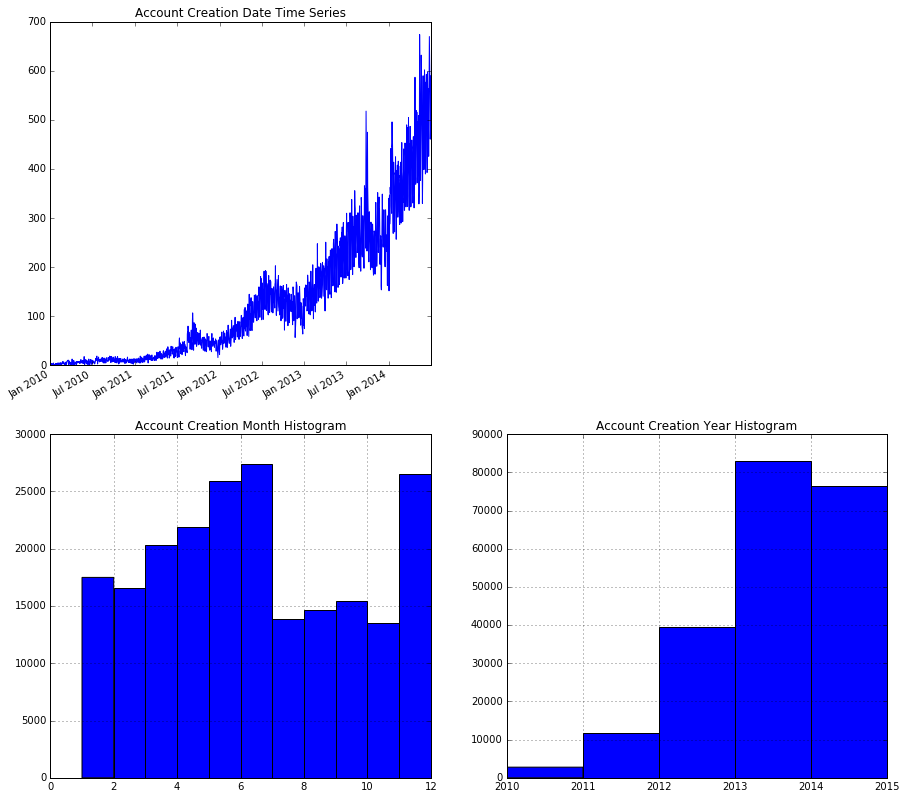

In [13]:
# Plot account created time series data.
plt.figure(figsize=(15, 15))
account_created_data = pd.to_datetime(train_data.date_account_created).value_counts()
plt.subplot(2, 2, 1)
account_created_data.plot()
plt.title("Account Creation Date Time Series")

# Plot account created month data.
account_created_month = pd.to_datetime(train_data.date_account_created).dt.month
plt.subplot(2, 2, 3)
account_created_month.hist(bins=range(1,13))
plt.title("Account Creation Month Histogram")

# Plot account created year data.
account_created_year = pd.to_datetime(train_data.date_account_created).dt.year
ax = plt.subplot(2, 2, 4)
account_created_year.hist(bins=[2010,2011,2012,2013,2014,2015])
ax.ticklabel_format(useOffset=False)
plt.title("Account Creation Year Histogram")

### Analysis of Session Data
Airbnb provided other data in addition to the training and test datasets. The "Session" dataset contains web sessions log for the users. The activity of a user could be indicative of intention to book.

In [24]:
# Import sessions data.
sessions= pd.read_csv('data/sessions.csv')

print(sessions.apply(lambda x: x.nunique(),axis=0))
print ""
sessions.head()

user_id          135483
action              359
action_type          10
action_detail       155
device_type          14
secs_elapsed     337661
dtype: int64



,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


In [32]:
# Aggregate sessions data to the user level.
grpby = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grpby.columns = ['user_id','secs_elapsed']

action_type = pd.pivot_table(sessions, index = ['user_id'],
                             columns = ['action_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()
device_type = pd.pivot_table(sessions, index = ['user_id'],
                             columns = ['device_type'],values = 'action',aggfunc=len,fill_value=0).reset_index()

sessions_data = pd.merge(action_type,device_type,on='user_id',how='inner')
sessions_data = pd.merge(sessions_data,grpby,on='user_id',how='inner')

# Join session data with train and test data.
joined_train_data = pd.concat([train_data, sessions_data], axis=1)
joined_test_data = pd.concat([test_data, sessions_data], axis=1, join='inner')

sessions_data.head()

,user_id,-unknown-_x,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,...,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,secs_elapsed
0,00023iyk9l,0,1,0,4,9,1,0,1,0,...,0,36,0,0,0,0,0,4,0,867896
1,0010k6l0om,5,0,0,16,9,0,0,1,0,...,0,63,0,0,0,0,0,0,0,586543
2,001wyh0pz8,6,0,0,66,2,0,0,0,3,...,0,0,0,0,0,0,0,0,0,282965
3,0028jgx1x1,1,0,0,9,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,297010
4,002qnbzfs5,184,1,0,140,140,16,0,0,15,...,0,0,0,0,0,0,0,775,0,6487080


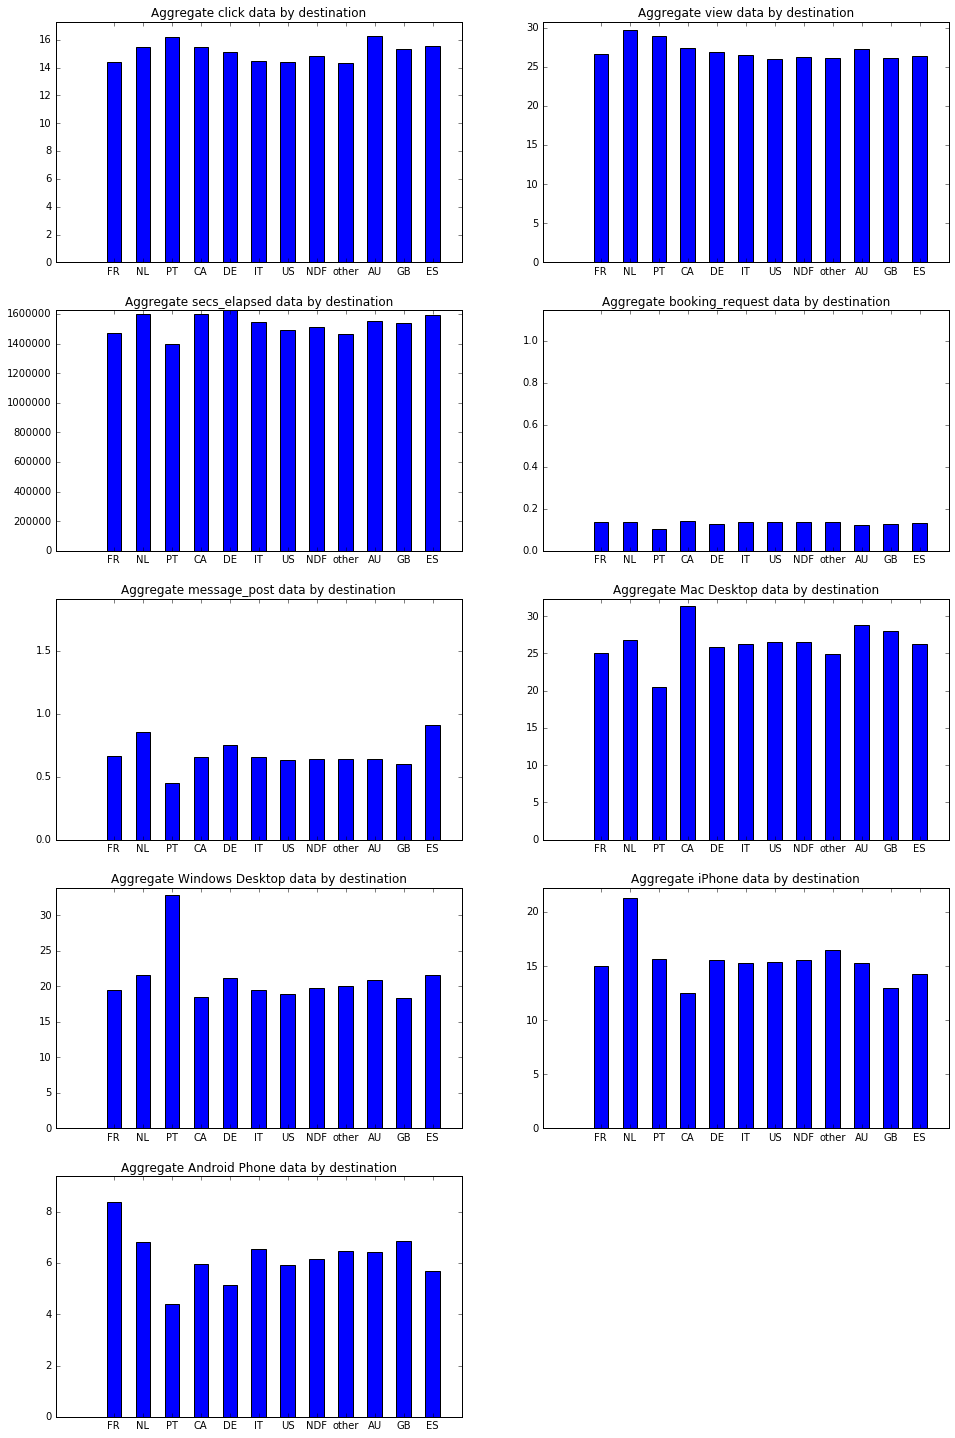

In [33]:
#Summary charts of Session Data by Country Destination
def SessionDataHist(column, plt_index):
    columns_to_extract = ['country_destination', column]
    agg_data = joined_train_data[columns_to_extract].groupby(
        ['country_destination'])[column].mean().reset_index()
    agg_dict = dict(zip(agg_data['country_destination'], agg_data[column]))
    X = np.arange(len(agg_dict))
    
    plt.subplot(5, 2, plt_index)
    plt.bar(X, agg_dict.values(), align='center', width=0.5)
    plt.xticks(X, agg_dict.keys())
    ymax = max(agg_dict.values()) + 1
    plt.ylim(0, ymax)
    plt.title("Aggregate {0} data by destination".format(column))

plt.figure(figsize=(16, 25))
# Choose some interesting columns to plot.
columns_to_plot = ['click', 'view', 'secs_elapsed', 'booking_request',
                   'message_post', 'Mac Desktop', 'Windows Desktop',
                   'iPhone', 'Android Phone']
for i,column in enumerate(columns_to_plot):
    SessionDataHist(column, i+1)

## Feature Engineering

In [43]:
# Helper function to extract features.
def ExtractFeatures(data):
    # Choose a subset of categorical columns.
    categorical_columns = ["gender", "signup_method", "language", "first_device_type", "first_browser"]
    categorical_values = np.array(data[categorical_columns])

    # Do the first column
    enc_label = preprocessing.LabelEncoder()
    features_data = enc_label.fit_transform(categorical_values[:,0])

    # Do the rest of the columns
    for i in range(1, categorical_values.shape[1]):
            enc_label = preprocessing.LabelEncoder()
            features_data = np.column_stack((features_data,
                                             enc_label.fit_transform(categorical_values[:,i])))

    # Add cleaned version of age data to features.
    age_data = CleanAgeData(data)
    age_buckets = age_data.divide(5).apply(np.floor)
    # Add age data to feature set.
    features_data = np.column_stack((features_data, np.array(age_buckets)))
 
    # Convert to matrix of ints.
    features_data = features_data.astype(int)
    return features_data

# Extract and format features for training and test data.
train_data_x = ExtractFeatures(joined_train_data)
test_data_x = ExtractFeatures(joined_test_data)
print "Train data shape: {0}".format(train_data_x.shape)
print "Test data shape: {0}".format(test_data_x.shape)

# Extract train labels.
train_data_y = np.array(train_data["country_destination"])
print "Train labels shape: {0}".format(train_data_y.shape)

Train data shape: (213451L, 6L)
Test data shape: (62096L, 6L)
Train labels shape: (213451L,)


## Model Development

### Training and Development Data

In [44]:
# Split train data into training and dev sets.
train_data_size = (len(train_data_x))/5*4
train_x, train_y = train_data_x[:train_data_size], train_data_y[:train_data_size]
dev_x, dev_y= train_data_x[train_data_size:], train_data_y[train_data_size:]

# save dev id to be used in score calculation
dev_id = np.array(train_data["id"][train_data_size:])
dev_dict = dict(zip(dev_id, dev_y))

print train_x.shape, train_y.shape
print dev_x.shape, dev_y.shape, dev_id.shape

(170760L, 6L) (170760L,)
(42691L, 6L) (42691L,) (42691L,)


### Scoring Functions

In [37]:
# Helper function to return top 5 prediction result per example given a trained model and target data set
def Predict_Top5(m, target='dev'):
    
    ds = dev_x
    if target == 'test': ds = test_data_x
        
    prob_est = m.predict_proba(ds)
    predictions = []
    
    for i, example in enumerate(prob_est):
        sorted_scores = np.sort(example)
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = example.tolist().index(score)
            
            if target == 'dev':
                predictions.append((dev_id[i], m.classes_[index_of_score]))
            elif target == 'test':
                predictions.append((test_data["id"][i], m.classes_[index_of_score]))
    
    return predictions

In [38]:
# Calculate DCG score based on Kaggle evaluation doc
def FinalScore(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            #scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    #scores.append((cur_id, dcg))
    
    return score/num_pred
    #return scores

In [39]:
# Build on top of DCG score function, output more prediction data
def Dump(predictions):
    to_print = False
    scores = []
    
    k, dcg, score, num_pred= 0, 0.0, 0.0, 0
    cur_id = predictions[0][0]
    
    for i, p in enumerate(predictions):
        if p[0] != cur_id:
            score += dcg
            num_pred +=1
            if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
            scores.append((cur_id, dcg))

            #start a new group
            k, dcg, cur_id = 0, 0.0, p[0]
            if to_print: print "\nnew id", cur_id

        k += 1  
        rel, mark = 0, '  X'
        if p[1] == dev_dict[cur_id]:
            rel, mark = 1, 'V'
        dcg += (pow(2,rel) - 1)*1. / math.log(k+1,2)

        if to_print: print i, mark, cur_id, p, p[1], k, dcg
    
    #process the last id group
    score += dcg
    num_pred +=1
    if to_print: print "id: %s -- DCG: %7.4f"%(cur_id, dcg)
    scores.append((cur_id, dcg))
    
    #Output more info for error analysis
    dev_scores = dict(scores)
    dump = []
    temp_list = []
    for i in range(len(dev_x)):        
        temp_list = [dev_id[i], dev_y[i], dev_scores[dev_id[i]]]        
        dump.append(dev_x[i].tolist() + temp_list) 

    output = pd.DataFrame(dump, columns=["gender", "signup_method", "language", "first_device_type", 
                                         "first_browser", "age", "id", "country","score"])
    output.to_csv("dev_x_score.csv", index=False)
    
    buckets = [1.0, 0.6309, 0.5, 0.4307, 0.3869, 0.0]    
    plt.figure(figsize=(15, 15))
    
    for i in range(len(buckets)):    
        pred_count = output[abs(output.score - buckets[i]) < 0.001].country.value_counts()
        plt.subplot(2, 3, i+1)
        pred_count.plot.bar()

        if(i<5):
            plt.title("Correct prediction on attempt " + str(i+1))
            print "\nCorrect prediction dist on attempt %d"%(i+1)
        else:
            plt.title("Incorrect prediction dist")
            print "\nIncorrect prediction dist"
            
        print pred_count
    
    print "\nDev score: %7.5f"%(score/num_pred)
    
    return 

### Multinomial Naive Bayes


In [52]:
# Train Naive Bayes Model.
mnb = MultinomialNB()
mnb.fit(train_x, train_y)
predictions = mnb.predict(dev_x)
print "Accuracy: {0}".format(mnb.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(mnb, 'dev')))

Accuracy: 0.592794734253
F1 score: 0.564509554404
DCG score: 0.807262139384


In [50]:
predictions = Predict_Top5(mnb, 'test')
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 6
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Correct prediction dist on attempt 1
NDF    19147
US      6160
Name: country, dtype: int64

Correct prediction dist on attempt 2
NDF      5781
US       5183
other     163
FR          9
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1459
NDF      1195
FR        224
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR       609
other    184
NDF      102
IT        75
GB         5
ES         1
DE         1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       291
other    185
ES       111
GB        72
NDF       29
DE         5
FR         5
Name: country, dtype: int64

Incorrect prediction dist
GB     358
ES     306
CA     300
IT     198
NL     160
DE     144
NDF     97
AU      77
PT      54
FR       1
Name: country, dtype: int64

Dev score: 0.80726


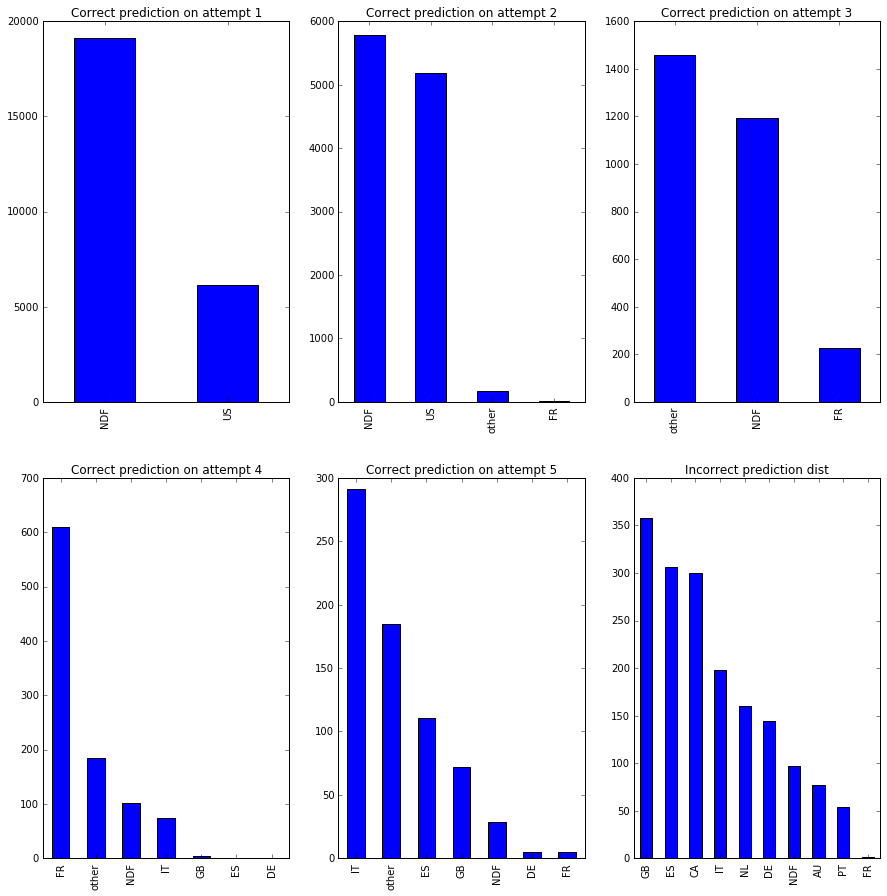

In [53]:
Dump(Predict_Top5(mnb, 'dev'))

### Logistic Regression

In [51]:
# Train Logistic Regression Model.
lr = LogisticRegression(penalty='l2')
lr.fit(train_x, train_y)
lr_predictions = lr.predict(dev_x)
print "Accuracy: {0}".format(lr.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,lr_predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(lr, 'dev')))

Accuracy: 0.627673280082
F1 score: 0.558686616831
DCG score: 0.825759509811


In [54]:
predictions = Predict_Top5(lr, 'test')
output3 = pd.DataFrame(predictions, columns=["id", "country"])
version = 6
output3.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Correct prediction dist on attempt 1
NDF    23239
US      3793
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       7550
NDF      3005
other      18
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1973
NDF        98
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR     848
NDF      8
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT     486
ES      39
GB      19
CA      18
NDF      1
DE       1
Name: country, dtype: int64

Incorrect prediction dist
GB    416
ES    379
CA    282
NL    160
DE    149
IT     78
AU     77
PT     54
Name: country, dtype: int64

Dev score: 0.82746


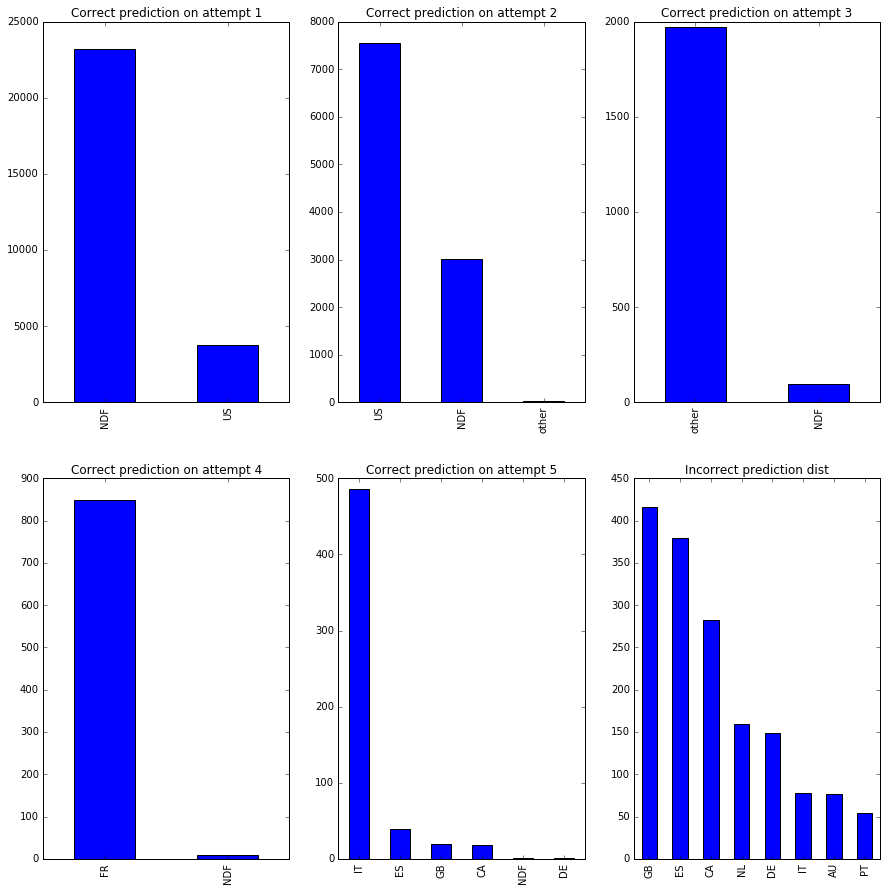

In [50]:
Dump(Predict_Top5(lr, 'dev'))

### Random Forest

In [55]:
# Train Random forest.
rf= RandomForestClassifier(n_estimators=50)
rf.fit(train_x, train_y)
rf_predictions = rf.predict(dev_x)
print "Accuracy: {0}".format(rf.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,rf_predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(rf, 'dev')))

Accuracy: 0.649785669111
F1 score: 0.605893913755
DCG score: 0.828827198208


In [56]:
predictions = Predict_Top5(rf, 'test')
output4 = pd.DataFrame(predictions, columns=["id", "country"])
version = 4
output4.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Correct prediction dist on attempt 1
NDF      22349
US        5388
other        3
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       5777
NDF      3918
other      20
IT          4
ES          1
FR          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1653
US         86
FR         79
NDF        52
IT         10
GB          4
DE          3
CA          2
NL          2
ES          1
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR       565
other    160
IT        31
ES        22
GB        22
US        14
NDF        7
CA         2
NL         1
DE         1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       246
FR        80
GB        76
ES        63
other     41
CA        13
DE         4
US         2
NL         2
AU         1
Name: country, dtype: int64

Incorrect prediction dist
GB       332
ES       331
CA       283
IT       273
NL       155
DE       142
FR       122
other    114
US        

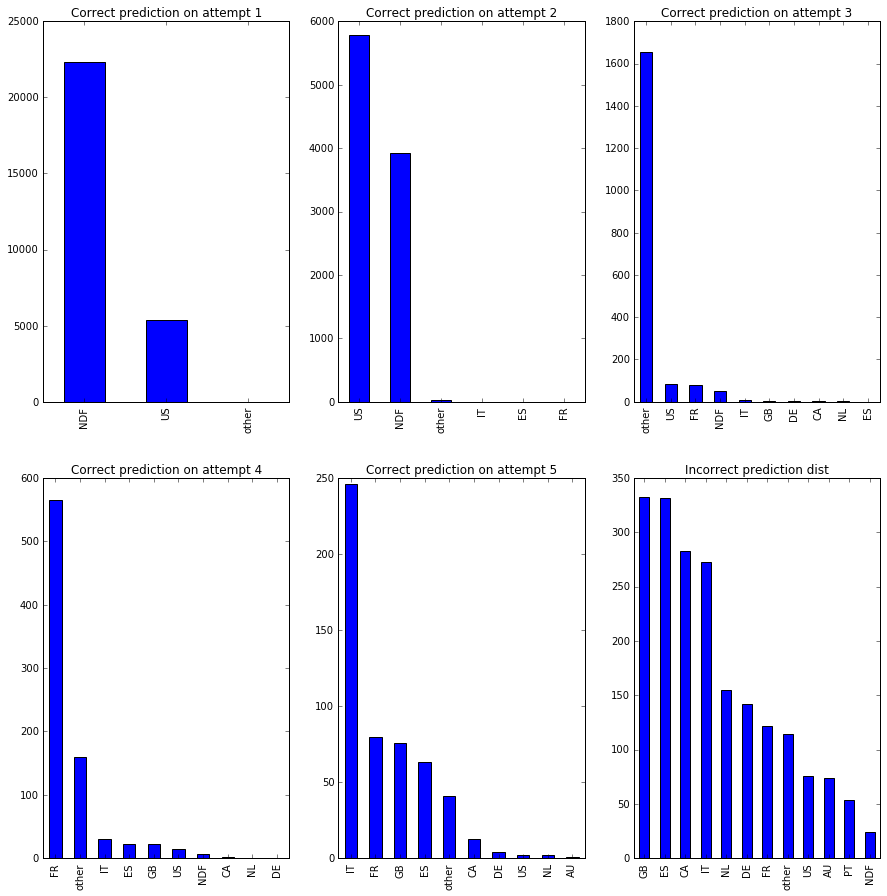

In [57]:
Dump(Predict_Top5(rf, 'dev'))

### Voting Classifier

In [58]:
# Try voting ensemble
vc = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc.fit(train_x, train_y)
vc_predictions = vc.predict(dev_x)
print "Accuracy: {0}".format(vc.score(dev_x, dev_y))
print "F1 score: {0}".format(metrics.f1_score(dev_y,vc_predictions,average="weighted"))
print "DCG score: {0}".format(FinalScore(Predict_Top5(vc, 'dev')))

Accuracy: 0.650956876157
F1 score: 0.605893913755
DCG score: 0.833642716143


In [59]:
predictions = Predict_Top5(vc, 'test')
output = pd.DataFrame(predictions, columns=["id", "country"])
version = 7
#output.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)


Correct prediction dist on attempt 1
NDF    22562
US      5228
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       6097
NDF      3775
other       2
IT          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1925
FR         21
US         18
NDF        13
IT          5
DE          3
ES          1
GB          1
NL          1
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR       741
other     48
IT        15
GB         9
ES         6
CA         2
NL         2
NDF        1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       350
GB        72
FR        66
ES        58
other     15
CA         4
DE         3
Name: country, dtype: int64

Incorrect prediction dist
ES       353
GB       353
CA       294
IT       193
NL       157
DE       144
AU        77
PT        54
FR        20
other      1
Name: country, dtype: int64

Dev score: 0.83364


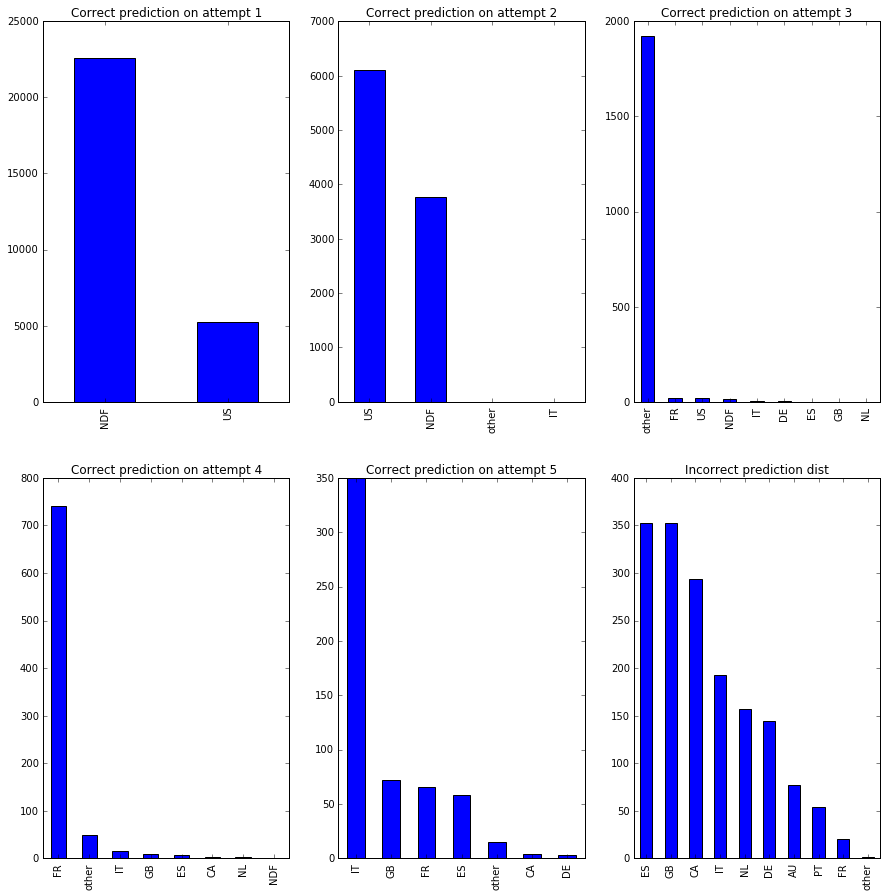

In [60]:
Dump(Predict_Top5(vc, 'dev'))

### Log of Improvements
1. Multinomial NB  (Baseline)
Baseline score: 0.63168  
Baseline rank: 1304  
2. Multinomial NB with Top 5 predictions  
Score: 0.79584  
Rank: 1142
3. Logistic Regression with Top 5 predictions  
Score: 0.85894  
Rank: 1049
4. Random Forest with Top 5 predictions  
Score: 0.81781  
Rank: 1138  
5. Logistic Regression with Age data clean-up  
Score improvement: 0.85970  
Rank improvement: 1044  
6. Soft voting with Logistic Regression and Random Forest   
Score improvement: 0.86252  
Rank improvement: 1032

## Project Challenges

### Imbalanced Data
The biggest challenge to the model was the imbalance of the class data. 2 destinations (NDF and US) represent 90% of the data. We attempted to oversample these classeses using the Synthetic Minority Oversampling Technique (SMOTE). This method was successful in improving the accuracy of the minority classes, but these gains were offset by lowered accuracy on the majority classes due to their large size.

One area of proposed future research would be to investigate other methods of handling imbalanced data that could improve accuracy on the minority classes without such detrimental effects to the majority classes.


#### SMOTE implementation
The following SMOTE function was copied from this source: http://comments.gmane.org/gmane.comp.python.scikit-learn/5278

In [61]:
def SMOTE(T, N, k):
    """
    Returns (N/100) * n_minority_samples synthetic minority samples.

    Parameters
    ----------
    T : array-like, shape = [n_minority_samples, n_features]
        Holds the minority samples
    N : percetange of new synthetic samples: 
        n_synthetic_samples = N/100 * n_minority_samples. Can be < 100.
    k : int. Number of nearest neighbours. 

    Returns
    -------
    S : array, shape = [(N/100) * n_minority_samples, n_features]
    """    
    n_minority_samples, n_features = T.shape
    
    if N < 100:
        #create synthetic samples only for a subset of T.
        #TODO: select random minortiy samples
        N = 100
        pass

    if (N % 100) != 0:
        raise ValueError("N must be < 100 or multiple of 100")
    
    N = N/100
    n_synthetic_samples = N * n_minority_samples
    S = np.zeros(shape=(n_synthetic_samples, n_features))
    
    #Learn nearest neighbours
    neigh = NearestNeighbors(n_neighbors = k)
    neigh.fit(T)
    
    #Calculate synthetic samples
    for i in xrange(n_minority_samples):
        nn = neigh.kneighbors(T[i], return_distance=False)
        for n in xrange(N):
            nn_index = random.choice(nn[0])
            #NOTE: nn includes T[i], we don't want to select it 
            while nn_index == i:
                nn_index = random.choice(nn[0])
                
            dif = T[nn_index] - T[i]
            gap = np.random.random()
            S[n + i * N, :] = T[i,:] + gap * dif[:]
    
    return S


Before adding synthetic examples:
Training set: (170760L, 6L) Label set: (170760L,)

After adding 1 time(s) of 'US' examples:
Training set: (175863L, 6L) Label set: (175863L,)

After adding 1 time(s) of 'other' examples:
Training set: (183966L, 6L) Label set: (183966L,)

After adding 1 time(s) of 'FR' examples:
Training set: (188141L, 6L) Label set: (188141L,)

After adding 1 time(s) of 'IT' examples:
Training set: (190412L, 6L) Label set: (190412L,)

After adding 1 time(s) of 'GB' examples:
Training set: (192301L, 6L) Label set: (192301L,)

After adding 1 time(s) of 'ES' examples:
Training set: (194132L, 6L) Label set: (194132L,)

After adding 2 time(s) of 'CA' examples:
Training set: (196388L, 6L) Label set: (196388L,)

After adding 2 time(s) of 'DE' examples:
Training set: (198210L, 6L) Label set: (198210L,)

After adding 2 time(s) of 'NL' examples:
Training set: (199414L, 6L) Label set: (199414L,)

After adding 2 time(s) of 'AU' examples:
Training set: (200338L, 6L) Label set: (20

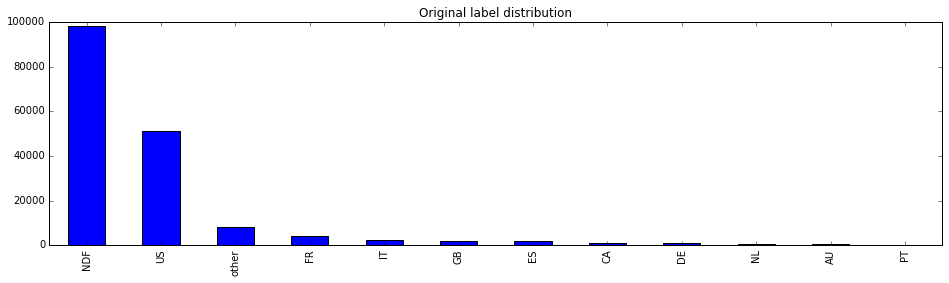

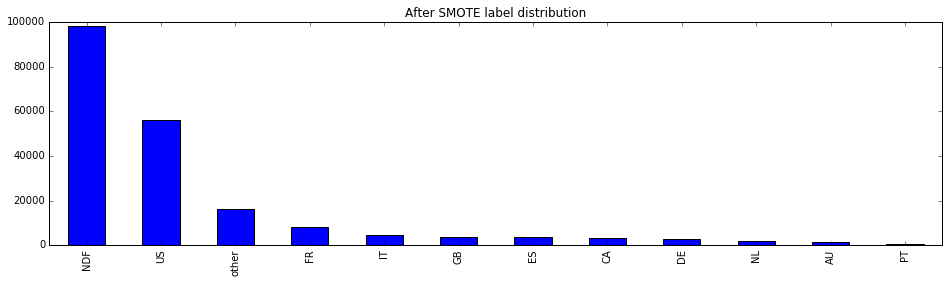

In [62]:
smote_countries = [('US',1), ('other',1),('FR',1),('IT',1),('GB',1),('ES',1),\
                       ('CA',2),('DE',2),('NL',2),('AU',2),('PT',2)]
    
#smote_countries = [('other',3),('FR',3)]

print "\nBefore adding synthetic examples:"
print "Training set: %s Label set: %s"%(str(train_x.shape), str(train_y.shape))

plt.figure(figsize=(16,4))
country_dist = pd.Series(train_y).value_counts()
plt.subplot(1,1,1)
country_dist.plot.bar()
plt.title('Original label distribution')

for i, c in enumerate(smote_countries):
    country, N = c[0], c[1]

    train_x_country = train_x[train_y == country]

    if country == 'US':
        size = train_x_country.shape[0] / 10
        train_x_country = train_x_country[:size]

    #SMOTE(minority data, new data size, NN steps)
    #To double minority data example size, set N=1
    #NN default = 5 neighbours
    train_x_new =  SMOTE(train_x_country,N*100,5)

    #Append new data to train_x
    train_x = np.vstack((train_x, train_x_new))

    #Append label to train_y
    new_label = []
    for i in range(N * len(train_x_country)):
        new_label.append(country)
    train_y = np.concatenate((train_y, np.array(new_label)))

    print "\nAfter adding %d time(s) of '%s' examples:"%(N, country)
    print "Training set: %s Label set: %s"%(str(train_x.shape), str(train_y.shape))

plt.figure(figsize=(16,4))
country_dist = pd.Series(train_y).value_counts()
plt.subplot(1,1,1)
country_dist.plot.bar()
plt.title('After SMOTE label distribution')


Correct prediction dist on attempt 1
NDF      22424
US        5412
other        1
Name: country, dtype: int64

Correct prediction dist on attempt 2
US       5912
NDF      3889
other       5
ES          1
IT          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
other    1918
NDF        33
FR         20
US         19
IT          4
NL          2
DE          1
GB          1
CA          1
Name: country, dtype: int64

Correct prediction dist on attempt 4
FR       729
other     59
IT        14
GB         7
NDF        5
ES         4
DE         2
CA         1
NL         1
Name: country, dtype: int64

Correct prediction dist on attempt 5
IT       329
FR        74
GB        62
ES        54
CA        27
DE         8
other      7
Name: country, dtype: int64

Incorrect prediction dist
GB       365
ES       359
CA       271
IT       216
NL       157
DE       139
AU        77
PT        54
FR        25
other      1
Name: country, dtype: int64

Dev score: 0.83380


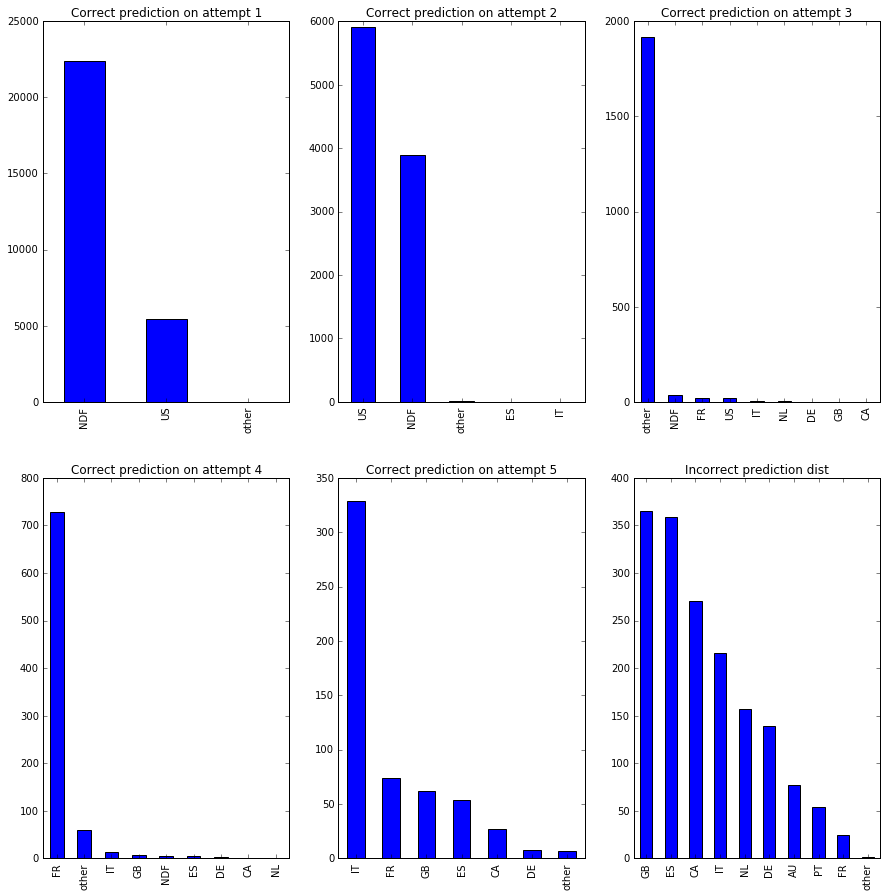

In [66]:
# Train Logistic Regression Model with SMOTE data
lr_sm = LogisticRegression(penalty='l2')
lr_sm.fit(train_x, train_y)

# Train Random forest SMOTE data
rf_sm= RandomForestClassifier(n_estimators=50)
rf_sm.fit(train_x, train_y)

# Voting ensemble with models on SMOTE Data
vc_sm = VotingClassifier(estimators=[ ('lr', lr), ('rf', rf)], voting='soft')
vc_sm.fit(train_x, train_y)
vc_sm_predictions = rf.predict(dev_x)

Dump(Predict_Top5(vc_sm, 'dev'))

### Model Simplicity vs Model Accuracy


#### 3-Level Model

In [56]:
# Use LabelBinarizer to transform training labels matrix of binary values.
lb = preprocessing.LabelBinarizer()
labels_train = lb.fit_transform(train_y)
labels_dev = lb.transform(dev_y)
print lb.classes_
# Note that NDF is index 7 and US is index 10.

['AU' 'CA' 'DE' 'ES' 'FR' 'GB' 'IT' 'NDF' 'NL' 'PT' 'US' 'other']


In [57]:
# Train Logistic Regression for NDF vs non-NDF.
lr_ndf = LogisticRegression(penalty='l2')
lr_ndf.fit(train_x, labels_train[:,7])
lr_ndf_predictions = lr_ndf.predict(dev_x)
print "NDF Logistic Regression F1 score: {0}".format(
    metrics.f1_score(labels_dev[:,7],lr_ndf_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(lr_ndf_predictions == labels_dev[:,7]))
print "Positive predictions: {0}".format(np.sum(lr_ndf_predictions==1))
print "Negative predictions: {0}".format(np.sum(lr_ndf_predictions==0))

NDF Logistic Regression F1 score: 0.753050529779
Num correct: 29779
Positive predictions: 25935
Negative predictions: 16756


In [58]:
# Train Logistic Regression for US vs non-US.
# Get all non-NDF examples
us_train_x = np.array(
    [train_x[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0)])
us_dev_x = np.array(
    [dev_x[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0)])
us_train_y = np.array(
    [labels_train[i,10] for i in range(len(labels_train)) if (labels_train[i,7] == 0)])
us_dev_y = np.array(
    [labels_dev[i,10] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0)])

# Train Logistic Regression model on non-NDF data to classify US vs Non-US.
lr_us = LogisticRegression(penalty='l2')
lr_us.fit(us_train_x, us_train_y)
lr_us_predictions = lr_us.predict(us_dev_x)
print "US Logistic Regression F1 score: {0}".format(
    metrics.f1_score(us_dev_y,lr_us_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(lr_us_predictions == us_dev_y))
print "Positive predictions: {0}".format(np.sum(lr_us_predictions==1))
print "Negative predictions: {0}".format(np.sum(lr_us_predictions==0))
print "\n"

rf_us= RandomForestClassifier()
rf_us.fit(us_train_x, us_train_y)
rf_us_predictions = rf_us.predict(us_dev_x)
print "US Random Forest F1 score: {0}".format(
    metrics.f1_score(us_dev_y,rf_us_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(rf_us_predictions == us_dev_y))
print "Positive predictions: {0}".format(np.sum(rf_us_predictions==1))
print "Negative predictions: {0}".format(np.sum(rf_us_predictions==0))
print "\n"

vc_us = VotingClassifier(estimators=[ ('lr', lr_us), ('rf', rf_us)], voting='soft')
vc_us.fit(us_train_x, us_train_y)
vc_us_predictions = vc_us.predict(us_dev_x)
print "US voting F1 score: {0}".format(
    metrics.f1_score(us_dev_y,vc_us_predictions,average="binary"))
print "Num correct: {0}".format(np.sum(vc_us_predictions == us_dev_y))
print "Positive predictions: {0}".format(np.sum(vc_us_predictions==1))
print "Negative predictions: {0}".format(np.sum(vc_us_predictions==0))

US Logistic Regression F1 score: 0.8175267065
Num correct: 11301
Positive predictions: 16272
Negative predictions: 68


US Random Forest F1 score: 0.783539934097
Num correct: 10822
Positive predictions: 14149
Negative predictions: 2191


US voting F1 score: 0.803144889554
Num correct: 11082
Positive predictions: 15367
Negative predictions: 973


In [59]:
# Train models for classifying non NDF/US examples.
# Get all non-NDF/US examples
other_train_x = np.array(
    [train_x[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0 and labels_train[i,10] == 0)])
other_train_y = np.array(
    [train_y[i] for i in range(len(labels_train)) if (labels_train[i,7] == 0 and labels_train[i,10] == 0)])
other_dev_x = np.array(
    [dev_x[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0 and labels_train[i,10] == 0)])
other_dev_y = np.array(
    [dev_y[i] for i in range(len(labels_dev)) if (labels_dev[i,7] == 0 and labels_train[i,10] == 0)])

lr_other = LogisticRegression(penalty='l2')
lr_other.fit(other_train_x, other_train_y)
lr_other_predictions = lr_other.predict(other_dev_x)
print "Non-NDF/US logistic regression F1 score: {0}".format(
    metrics.f1_score(other_dev_y,lr_other_predictions,average="weighted"))

rf_other= RandomForestClassifier()
rf_other.fit(other_train_x, other_train_y)
rf_other_predictions = rf_other.predict(other_dev_x)
print "Non-NDF/US random forest F1 score: {0}".format(
    metrics.f1_score(other_dev_y,rf_other_predictions,average="weighted"))

vc_other = VotingClassifier(estimators=[ ('lr', lr_other), ('rf', rf_other)], voting='soft')
vc_other.fit(other_train_x, other_train_y)
vc_other_predictions = vc_other.predict(other_dev_x)
print "Non-NDF/US voting F1 score: {0}".format(
    metrics.f1_score(other_dev_y,vc_other_predictions,average="weighted"))

Non-NDF/US logistic regression F1 score: 0.0264627676823
Non-NDF/US random forest F1 score: 0.0333738231458
Non-NDF/US voting F1 score: 0.031105358481


Case 1 count: 18964
Case 2 count: 22996
Case 3 count: 731
Final Score: 0.707488159264

Correct prediction dist on attempt 1
NDF      14889
US        8550
other       48
Name: country, dtype: int64

Correct prediction dist on attempt 2
NDF      6914
US       2495
other     704
FR         36
IT          5
GB          2
NL          1
ES          1
CA          1
Name: country, dtype: int64

Correct prediction dist on attempt 3
FR       217
other     47
IT        14
GB         9
ES         2
CA         2
DE         1
Name: country, dtype: int64

Correct prediction dist on attempt 4
IT       61
FR       53
GB       42
ES       20
CA       19
other    10
DE        3
Name: country, dtype: int64

Correct prediction dist on attempt 5
GB       52
IT       50
CA       43
ES       21
FR       10
DE        4
other     2
NL        2
Name: country, dtype: int64

Incorrect prediction dist
NDF      4548
other    1180
FR        532
IT        434
ES        374
GB        330
US        298
CA        235
NL 

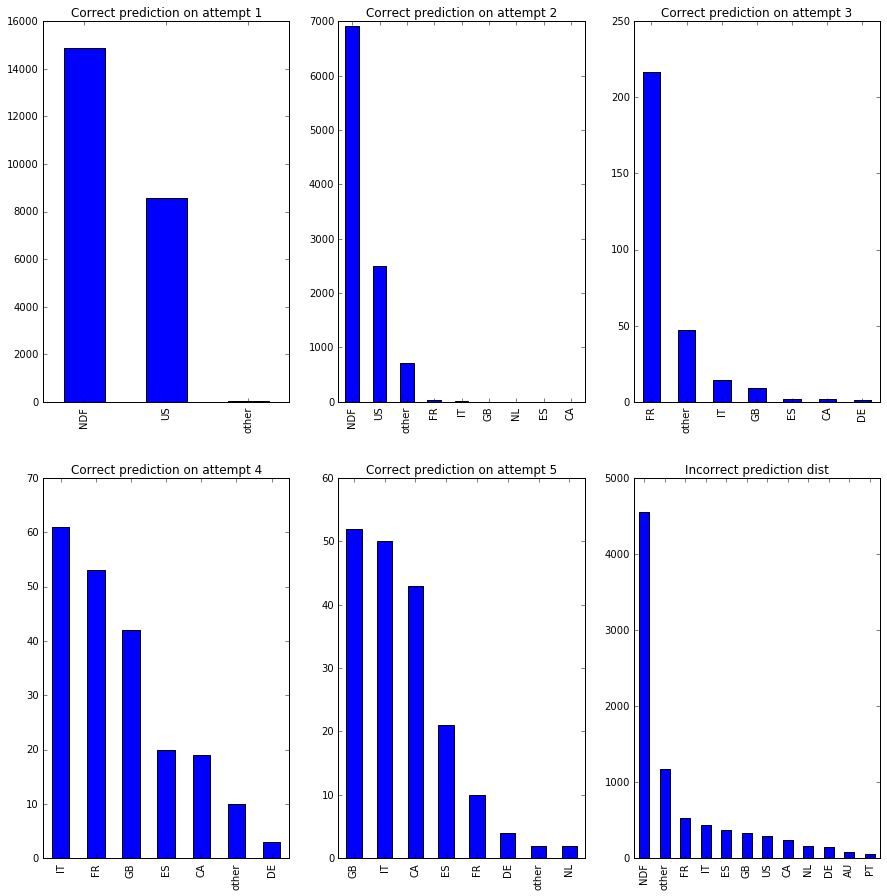

In [60]:
# Create a 3-level model using NDF, US, and other models.
# Compute accuracy on dev set.
lr_ndf_dev_prob = lr_ndf.predict_proba(dev_x)
lr_us_dev_prob = rf_us.predict_proba(dev_x)
vc_other_dev_prob = vc_other.predict_proba(dev_x)
predictions = []
case1, case2, case3 = 0, 0, 0
for i in range(dev_x.shape[0]):
    ndf_prob = lr_ndf_dev_prob[i][1]
    us_prob = lr_us_dev_prob[i][1]
    max_other_prob = np.max(vc_other_dev_prob[i])
    if (ndf_prob > us_prob and ndf_prob > max_other_prob):
        case1+=1
        predictions.append((dev_id[i], 'NDF'))
        if (us_prob > max_other_prob):
            predictions.append((dev_id[i], 'US'))
        else:
            sorted_scores = np.sort(vc_other_dev_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_dev_prob[i].tolist().index(score)
                predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
    elif (us_prob > ndf_prob and us_prob > max_other_prob):
        case2+=1
        predictions.append((dev_id[i], 'US'))
        if (ndf_prob > max_other_prob):
            predictions.append((dev_id[i], 'NDF'))
        else:
            sorted_scores = np.sort(vc_other_dev_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_dev_prob[i].tolist().index(score)
                predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
    else:
        case3+=1
        sorted_scores = np.sort(vc_other_dev_prob[i])
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = vc_other_dev_prob[i].tolist().index(score)
            predictions.append((dev_id[i], vc_other.classes_[index_of_score]))
print "Case 1 count: {0}".format(case1)
print "Case 2 count: {0}".format(case2)
print "Case 3 count: {0}".format(case3)
print "Final Score: {0}".format(FinalScore(predictions))
Dump(predictions)

In [61]:
# Run 3-level model on test data.
lr_ndf_predictions_test = lr_ndf.predict(test_data_x)
lr_us_predictions_test = lr_us.predict(test_data_x)
vc_other_test_prob = vc_other.predict_proba(test_data_x)
predictions = []
for i in range(test_data_x.shape[0]):
    if (lr_ndf_predictions_test[i] == 1):
        predictions.append((test_data["id"][i], 'NDF'))
        if (lr_us_predictions_test[i] == 1):
            predictions.append((test_data["id"][i], 'US'))
        else:
            sorted_scores = np.sort(vc_other_test_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_test_prob[i].tolist().index(score)
                predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
    elif (lr_us_predictions_test[i] == 1):
        predictions.append((test_data["id"][i], 'US'))
        if (lr_ndf_predictions_test[i] == 1):
            predictions.append((test_data["id"][i], 'NDF'))
        else:
            sorted_scores = np.sort(vc_other_test_prob[i])
            top_4 = sorted_scores[len(sorted_scores) - 4:]
            for score in reversed(top_4):
                index_of_score = vc_other_test_prob[i].tolist().index(score)
                predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
    else:
        sorted_scores = np.sort(vc_other_test_prob[i])
        top_5 = sorted_scores[len(sorted_scores) - 5:]
        for score in reversed(top_5):
            index_of_score = vc_other_test_prob[i].tolist().index(score)
            predictions.append((test_data["id"][i], vc_other.classes_[index_of_score]))
# output8 = pd.DataFrame(predictions, columns=["id", "country"])
# version = 8
# output8.to_csv("submissions/shared_submission_{0}.csv".format(version), index=False)

# Error Analysis

In [62]:
import operator
def error_analysis(model, dev_x, dev_y):
    """
    Due to the large frequence of NDFs, the matrix needs to be normalized if we're to see anything helpful in this viz.
    """
    preds = model.predict(dev_x) ##Compute predictions given model
    labels = ['AU', 'CA', 'DE', 'ES', 'FR', 'GB', 'IT', 'NDF', 'NL', 'PT', 'US', 'other']    
    ###Accuracy Statistics###
    print 'FinalScore metric value: ', FinalScore(Predict_Top5(model, 'dev'))
    print "precision answers: where we measure 'country', what fraction actually was 'country'?"
    print "recall answers: of all that were 'country', what fraction did we correctly predict 'country'?"
    print "goal is to have both high precision and recall scores"
    print 'Precision and Recall scores: \n'
    precision = []
    recall = []
    for country in labels:
        binarized_devy = dev_y == country
        binarized_preds = preds == country
        precision.append(metrics.precision_score(binarized_devy, binarized_preds))
        recall.append(metrics.recall_score(binarized_devy, binarized_preds))
    p_r_dict = {'precision':precision, 'recall':recall}
    p_r_df = pd.DataFrame(p_r_dict, index=labels)
    print p_r_df
    ###Confusion Matrix###
    c_matx = metrics.confusion_matrix(dev_y, preds)
    c_matx_n = c_matx.astype('float') / c_matx.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plt.imshow(c_matx_n, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ###Error count###
    sums = {}
    series = {}
    for i in range(len(c_matx)):
        sums[labels[i]] = 0
        labs = []
        data = []
        for j in range(len(c_matx[i])):
            if i != j:
                sums[labels[i]] += c_matx[i][j]
                labs.append(labels[j])
                data.append(c_matx[i][j])
        series[labels[i]] = pd.Series(data, index=labs)
        series[labels[i]].sort_values(inplace=True, ascending=False)
    sorted_sums = sorted(sums.items(), key=operator.itemgetter(1), reverse=True)
    error_counts = pd.Series([x[1] for x in sorted_sums], [x[0] for x in sorted_sums])
    print 'Error Counts: \n\n', error_counts
    ###Top 5 Error Histograms###
    plt.figure(figsize=(15, 30))
    plt_indx = 1
    for country in [x[0] for x in sorted_sums[0:5]]:
        plt.subplot(5,1,plt_indx)
        series[country].plot.bar()
        plt.title("For '" + country + "' the model incorrectly guessed...")
        plt_indx += 1

FinalScore metric value:  0.833871336758
precision answers: where we measure 'country', what fraction actually was 'country'?
recall answers: of all that were 'country', what fraction did we correctly predict 'country'?
goal is to have both high precision and recall scores
Precision and Recall scores: 

       precision    recall
AU      0.000000  0.000000
CA      0.000000  0.000000
DE      0.000000  0.000000
ES      0.000000  0.000000
FR      0.000000  0.000000
GB      0.000000  0.000000
IT      0.000000  0.000000
NDF     0.721745  0.847710
NL      0.000000  0.000000
PT      0.000000  0.000000
US      0.470407  0.484881
other   0.103448  0.001507
Error Counts: 

US       5843
NDF      4013
other    1988
FR        848
IT        564
GB        435
ES        418
CA        300
NL        160
DE        150
AU         77
PT         54
dtype: int64


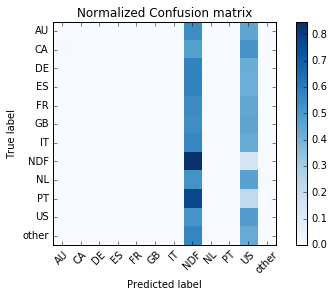

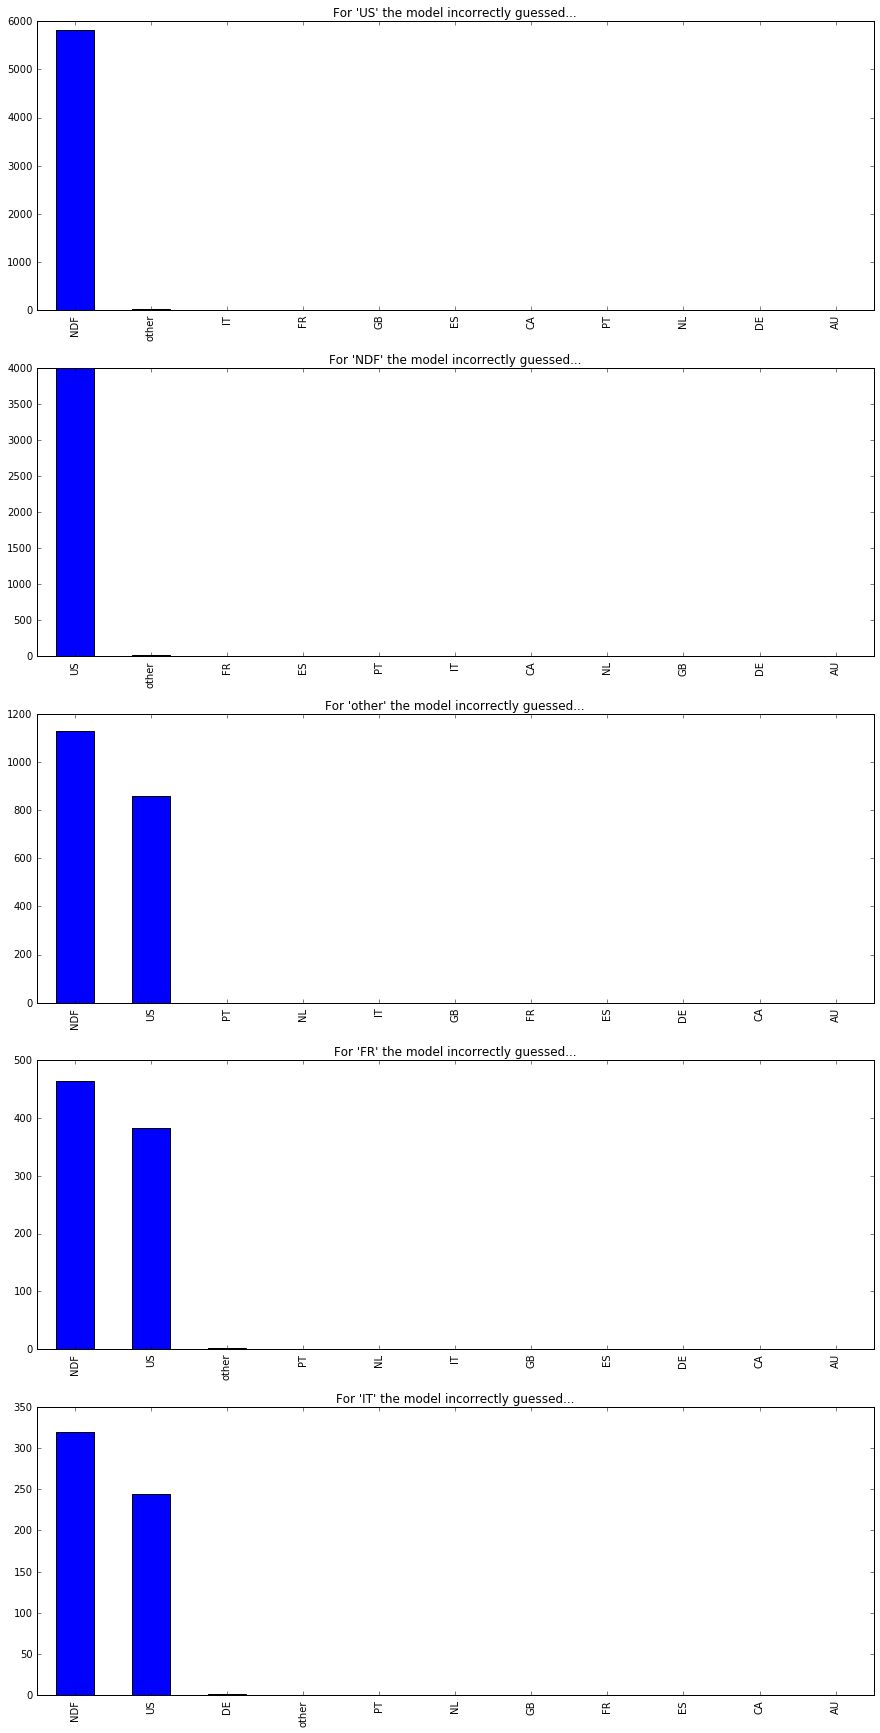

In [63]:
error_analysis(vc, dev_x, dev_y)